### Machine Learning using Regression models
### Date: May 24, 2025
### Author: Hincal Topcuoglu, Ph.D.

### We start by loading or libraries and functions.

In [55]:
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns
import statsmodels.api as sm
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import mean_absolute_error
from scipy.stats import boxcox
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import shapiro, probplot
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats.mstats import winsorize
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

### Load the data and have a first look.

In [2]:
data = pd.read_csv('insurance.csv')

In [3]:
data.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


OK, this is our data. We want to predict insurance expenses for individuals. We want to use the information in our data to make predictions out of sample that are as accurate as possible.

But first, let's get to know our data and see what we have to work with.

How many observations do we have?

In [4]:
len(data)

1338

Get a first set of descriptive statistics for the continuous variables.

What do we see? Missing data? Skewness of distribtution?

In [5]:
data.describe()

,age,bmi,children,expenses
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.665471,1.094918,13270.422414
std,14.049960,6.098382,1.205493,12110.011240
min,18.000000,16.000000,0.000000,1121.870000
25%,27.000000,26.300000,0.000000,4740.287500
50%,39.000000,30.400000,1.000000,9382.030000
75%,51.000000,34.700000,2.000000,16639.915000
max,64.000000,53.100000,5.000000,63770.430000


Missing data for the categorical variables?

In [6]:
data.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
expenses    0
dtype: int64

OK, great, no missing data to worry about.

When you look at the continuous variables, what do you think we should be looking at next?

In [7]:
data.describe()

,age,bmi,children,expenses
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.665471,1.094918,13270.422414
std,14.049960,6.098382,1.205493,12110.011240
min,18.000000,16.000000,0.000000,1121.870000
25%,27.000000,26.300000,0.000000,4740.287500
50%,39.000000,30.400000,1.000000,9382.030000
75%,51.000000,34.700000,2.000000,16639.915000
max,64.000000,53.100000,5.000000,63770.430000


Hincal comment : There is no need for now to normalize continous variables, firstly we should understandt what is the regression model does with these variables

old comment : Given the differences in measurment scales, we should normalized the continuous variables. In order to keep the original variables, we will generate new variables for the normalized continuous variables.

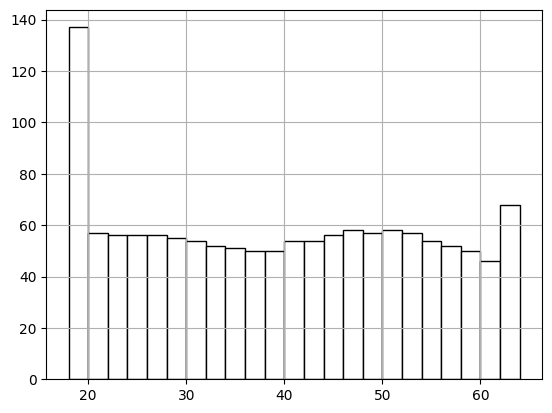

In [8]:
data.age.hist(bins=np.arange(min(data.age), max(data.age) + 2,2),
                                   range=[0,70],color="white",edgecolor="black")

plt.show()

Hincal comment: in age variable there is no variability except for age 0-20

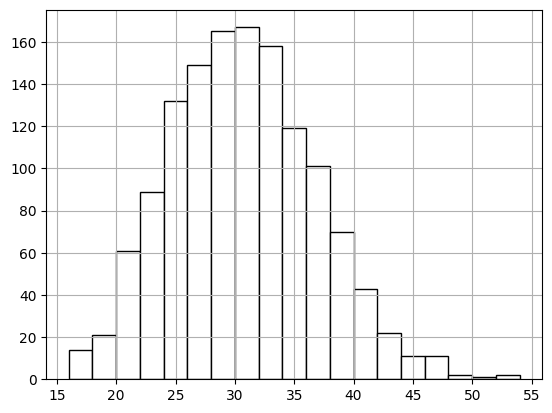

In [9]:
data.bmi.hist(bins=np.arange(min(data.bmi), max(data.bmi) + 2,2),
                                   range=[0,60],color="white",edgecolor="black")

plt.show()

Hincal comment: bmi index seems as normal distribution, it is good to test it also it shows a normal distribution with statistical tests. but from this graph, I can say we can use this variable to predict expenses if expenses have normal distribution too

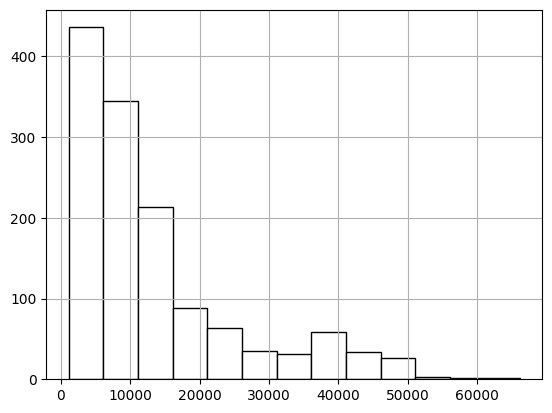

In [10]:
data.expenses.hist(bins=np.arange(min(data.expenses), max(data.expenses) + 5000,5000),
                                   range=[0,65000],color="white",edgecolor="black")

plt.show()

Hincal comment: target variable expenses have positive skewed data. we can make a log transformation to make it normally distributed. We do it because, Linear Regression models theoretically assumes that errors and so by target variable should have normal distribution

In [11]:
data['log_expenses'] = np.log(data['expenses'])

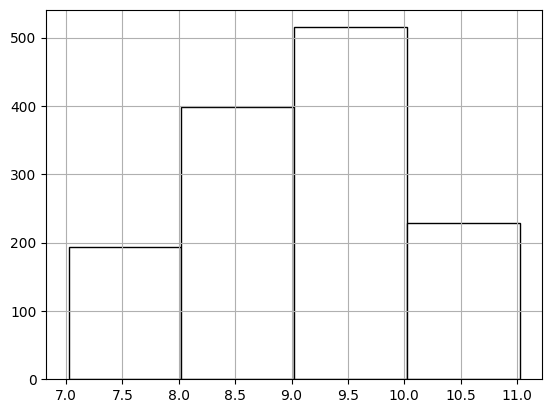

In [14]:
data.log_expenses.hist(bins=np.arange(min(data.log_expenses), max(data.log_expenses)),
                                   color="white",edgecolor="black")

plt.show()

Hincal comment: now it seems more normally distributed

Hincal comment: lets also apply square root transformation

In [15]:
data['sqrt_expenses'] = np.sqrt(data['expenses'])

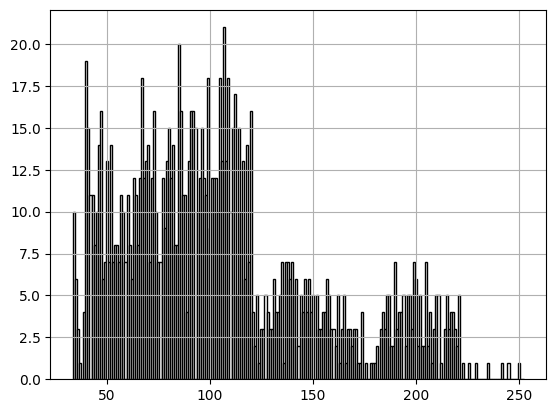

In [16]:
data.sqrt_expenses.hist(bins=np.arange(min(data.sqrt_expenses), max(data.sqrt_expenses)),
                                   color="white",edgecolor="black")

plt.show()

Hincal Comment: There is still positive skew in square root transformation comparing to log transformation

Hincal Comment : Lastly lets use box-cox tranformation

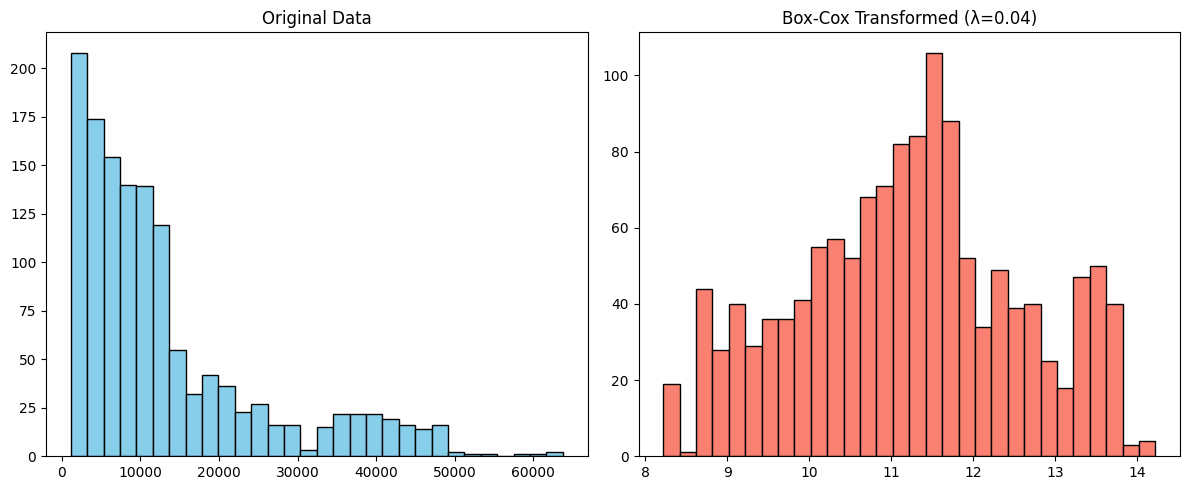

In [17]:
from scipy.stats import boxcox
transformed, fitted_lambda = boxcox(data['expenses'])

# Plot original and transformed data
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(data['expenses'], bins=30, color='skyblue', edgecolor='black')
axes[0].set_title('Original Data')

axes[1].hist(transformed, bins=30, color='salmon', edgecolor='black')
axes[1].set_title(f'Box-Cox Transformed (λ={fitted_lambda:.2f})')

plt.tight_layout()
plt.show()

Hincal comment: very good transformation

Hincal Comment: Lets append all transformed variables to main dataframe and then check if they are distributed normally

In [18]:
# Log transformation (add 1 if there are zeros to avoid log(0))
data['expenses_log'] = np.log(data['expenses'] + 1)

# Square root transformation
data['expenses_sqrt'] = np.sqrt(data['expenses'])

# Box-Cox transformation (data must be strictly positive)
# If there are zeros or negatives, you need to shift the data
expenses_positive = data['expenses'] + 1 if (data['expenses'] <= 0).any() else data['expenses']
data['expenses_boxcox'], fitted_lambda = boxcox(expenses_positive)

In [20]:
## lets look at data
data.head()

,age,sex,bmi,children,smoker,region,expenses,log_expenses,sqrt_expenses,expenses_log,expenses_sqrt,expenses_boxcox
0,19,female,27.9,0,yes,southwest,16884.92,9.734176,129.941987,9.734235,129.941987,12.128977
1,18,male,33.8,1,no,southeast,1725.55,7.453301,41.539740,7.453880,41.539740,8.808593
2,28,male,33.0,3,no,southeast,4449.46,8.400538,66.704273,8.400763,66.704273,10.147519
3,33,male,22.7,0,no,northwest,21984.47,9.998092,148.271609,9.998137,148.271609,12.534948
4,32,male,28.9,0,no,northwest,3866.86,8.260198,62.184082,8.260457,62.184082,9.945637


Hincal Comment: Let's plot all transformed variables with original target variable

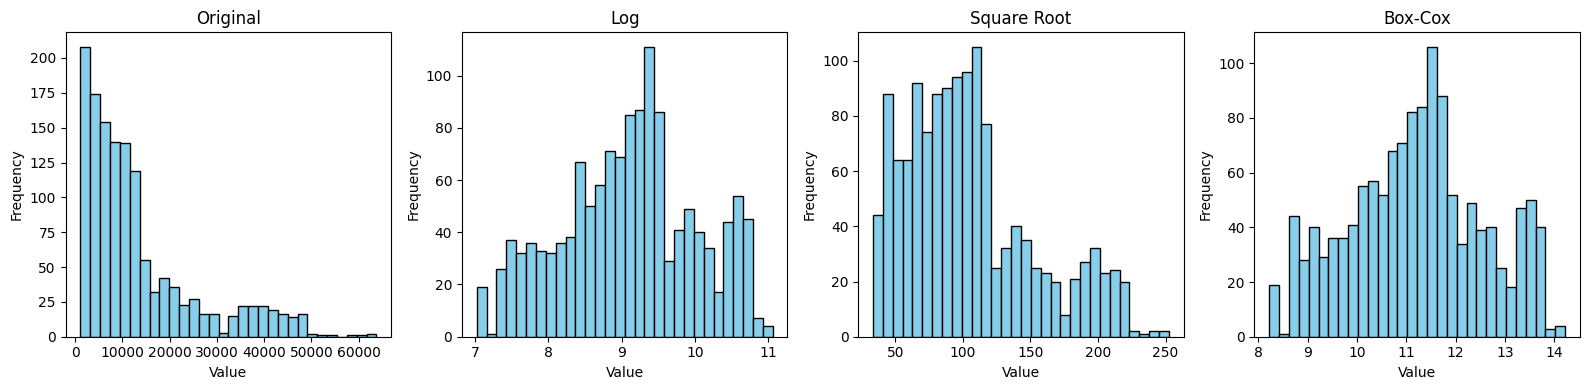

In [22]:
# List of columns to plot
columns = ['expenses', 'expenses_log', 'expenses_sqrt', 'expenses_boxcox']
titles = ['Original', 'Log', 'Square Root', 'Box-Cox']

plt.figure(figsize=(16, 4))

for i, (col, title) in enumerate(zip(columns, titles), 1):
    plt.subplot(1, 4, i)
    plt.hist(data[col], bins=30, color='skyblue', edgecolor='black')
    plt.title(title)
    plt.xlabel('Value')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Hincal Comment: Since log and box-cox transformations are theoratically same up to a point, it is reasonable to use them as target variable. but before it we should make a test that checks variable has normal distribution

In [24]:
columns = ['expenses', 'expenses_log', 'expenses_sqrt', 'expenses_boxcox']

for col in columns:
    stat, p = shapiro(data[col])
    print(f"{col}: W={stat:.4f}, p-value={p:.4f}")
    if p > 0.05:
        print("  Likely normal (fail to reject H0)")
    else:
        print("  Not normal (reject H0)")

expenses: W=0.8147, p-value=0.0000
  Not normal (reject H0)
expenses_log: W=0.9832, p-value=0.0000
  Not normal (reject H0)
expenses_sqrt: W=0.9339, p-value=0.0000
  Not normal (reject H0)
expenses_boxcox: W=0.9835, p-value=0.0000
  Not normal (reject H0)


Hincal Comment: Since target variable doesnt show normal distribution, it is not so important, we only tried to make it normally distributed to get good predictions. However now we will fit a base model and then check errors distribution. It is important that errors are normally distributed

In [26]:
data.head()

,age,sex,bmi,children,smoker,region,expenses,log_expenses,sqrt_expenses,expenses_log,expenses_sqrt,expenses_boxcox
0,19,female,27.9,0,yes,southwest,16884.92,9.734176,129.941987,9.734235,129.941987,12.128977
1,18,male,33.8,1,no,southeast,1725.55,7.453301,41.539740,7.453880,41.539740,8.808593
2,28,male,33.0,3,no,southeast,4449.46,8.400538,66.704273,8.400763,66.704273,10.147519
3,33,male,22.7,0,no,northwest,21984.47,9.998092,148.271609,9.998137,148.271609,12.534948
4,32,male,28.9,0,no,northwest,3866.86,8.260198,62.184082,8.260457,62.184082,9.945637


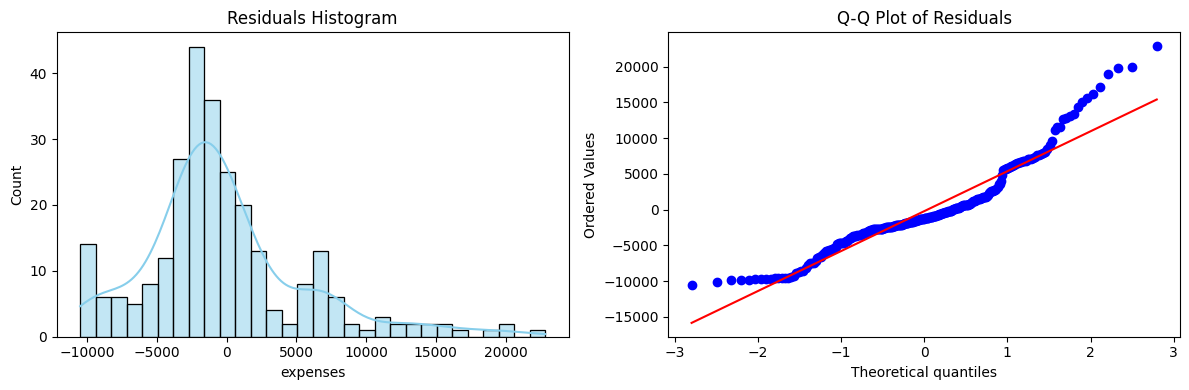

Shapiro-Wilk test: W=0.9140, p-value=0.0000
Residuals are not normal (reject H0)


In [27]:
# Select features and target
features = ['age', 'sex', 'bmi', 'children', 'smoker', 'region']
target = 'expenses'

# One-hot encode categorical variables
df_encoded = pd.get_dummies(data[features], drop_first=True)

# Split data
X_train, X_test, y_train, y_test = train_test_split(df_encoded, data[target], test_size=0.2, random_state=42)

# Fit linear regression
model = LinearRegression()
model.fit(X_train, y_train)

# Predict and calculate residuals
y_pred = model.predict(X_test)
residuals = y_test - y_pred

# Plot residuals histogram
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(residuals, bins=30, kde=True, color='skyblue')
plt.title('Residuals Histogram')

# Q-Q plot
plt.subplot(1, 2, 2)
probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')

plt.tight_layout()
plt.show()

# Shapiro-Wilk test
stat, p = shapiro(residuals)
print(f"Shapiro-Wilk test: W={stat:.4f}, p-value={p:.4f}")
if p > 0.05:
    print("Residuals are likely normal (fail to reject H0)")
else:
    print("Residuals are not normal (reject H0)")

Hincal comment: With original target varible, when we setup a linear regression model, we can see that residuals are not normally distributed

Hincal comment: Lets use transformed target variable for example box-cox transformation

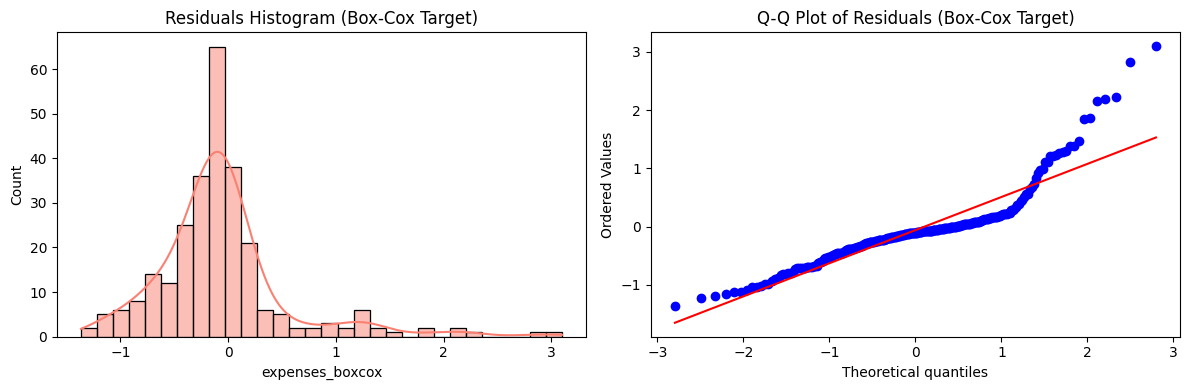

Shapiro-Wilk test: W=0.8417, p-value=0.0000
Residuals are not normal (reject H0)


In [29]:
# Select features and new target
features = ['age', 'sex', 'bmi', 'children', 'smoker', 'region']
target = 'expenses_boxcox'

# One-hot encode categorical variables
df_encoded = pd.get_dummies(data[features], drop_first=True)

# Split data
X_train, X_test, y_train, y_test = train_test_split(df_encoded, data[target], test_size=0.2, random_state=42)

# Fit linear regression
model = LinearRegression()
model.fit(X_train, y_train)

# Predict and calculate residuals
y_pred = model.predict(X_test)
residuals = y_test - y_pred

# Plot residuals histogram and Q-Q plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(residuals, bins=30, kde=True, color='salmon')
plt.title('Residuals Histogram (Box-Cox Target)')

plt.subplot(1, 2, 2)
probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals (Box-Cox Target)')

plt.tight_layout()
plt.show()

# Shapiro-Wilk test
stat, p = shapiro(residuals)
print(f"Shapiro-Wilk test: W={stat:.4f}, p-value={p:.4f}")
if p > 0.05:
    print("Residuals are likely normal (fail to reject H0)")
else:
    print("Residuals are not normal (reject H0)")

What Does This Mean?

Transforming the target variable (even with Box-Cox) did not achieve normal residuals.

This is common with real-world insurance data, which often has complex, nonlinear relationships and outliers that linear regression cannot fully capture.

The issue may be due to:
Nonlinear relationships between features and the target
Important features missing from the model
Outliers or heteroscedasticity (non-constant variance of residuals)

In [30]:
data.head()

,age,sex,bmi,children,smoker,region,expenses,log_expenses,sqrt_expenses,expenses_log,expenses_sqrt,expenses_boxcox
0,19,female,27.9,0,yes,southwest,16884.92,9.734176,129.941987,9.734235,129.941987,12.128977
1,18,male,33.8,1,no,southeast,1725.55,7.453301,41.539740,7.453880,41.539740,8.808593
2,28,male,33.0,3,no,southeast,4449.46,8.400538,66.704273,8.400763,66.704273,10.147519
3,33,male,22.7,0,no,northwest,21984.47,9.998092,148.271609,9.998137,148.271609,12.534948
4,32,male,28.9,0,no,northwest,3866.86,8.260198,62.184082,8.260457,62.184082,9.945637


Hincal Comment: no problem up to now, because we are learning linear regression model concept. we can handle this kind of data with non-linear approaches but for now it is out of scope.   
lets check the correlation between predictors and possible two target variables.

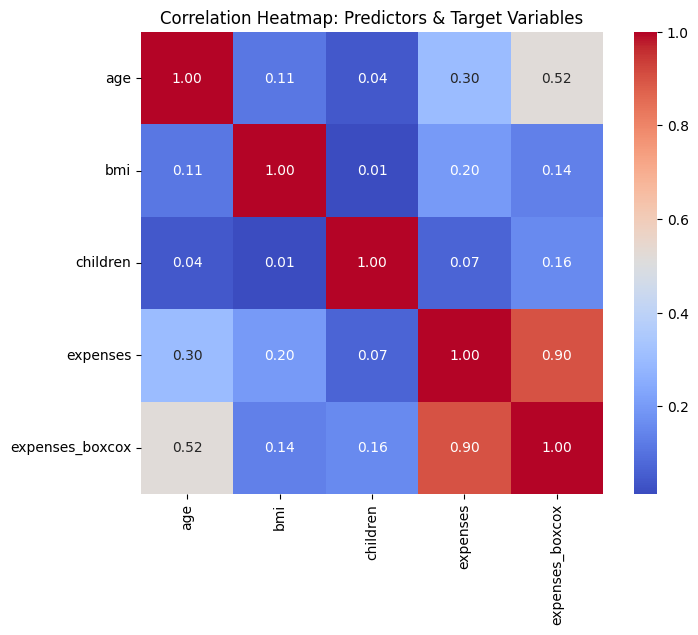

In [31]:
# Select predictors and target variables
predictors = ['age', 'bmi', 'children']  # Only numeric predictors for correlation
corr_targets = ['expenses', 'expenses_boxcox']

# Prepare DataFrame for correlation
corr_df = data[predictors + corr_targets]

# Compute correlation matrix
corr_matrix = corr_df.corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Heatmap: Predictors & Target Variables')
plt.show()

Hincal Comment: we can see from that, except for bmi variable, other predictors are more correlated with box-cox transformed variables

Hincal Comment: Lets apply linear regression base model to box-cox transformed target variable

In [33]:
# Select features and target
features = ['age', 'bmi', 'children', 'smoker', 'region']
target = 'expenses_boxcox'

# One-hot encode categorical variables
X = pd.get_dummies(data[features], drop_first=True)
y = data[target]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit linear regression
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Metrics
metrics = {}
metrics['Train R2'] = r2_score(y_train, y_train_pred)
metrics['Test R2'] = r2_score(y_test, y_test_pred)
metrics['Train MSE'] = mean_squared_error(y_train, y_train_pred)
metrics['Test MSE'] = mean_squared_error(y_test, y_test_pred)
metrics['Train MAE'] = mean_absolute_error(y_train, y_train_pred)
metrics['Test MAE'] = mean_absolute_error(y_test, y_test_pred)

metrics

{'Train R2': 0.7588448768579072,
 'Test R2': 0.8055850272992153,
 'Train MSE': 0.4422425750388109,
 'Test MSE': 0.38624571235314836,
 'Train MAE': 0.4204929129338991,
 'Test MAE': 0.4024848158038713}

Hincal Comment:

Interpretation:

The model explains about 76% of the variance in the training set and 81% in the test set, which is quite good for a linear regression on real-world data.
The mean squared error (MSE) and mean absolute error (MAE) are similar between train and test, indicating no major overfitting.

Hincal Comment: lets see coefficients, and residual plots

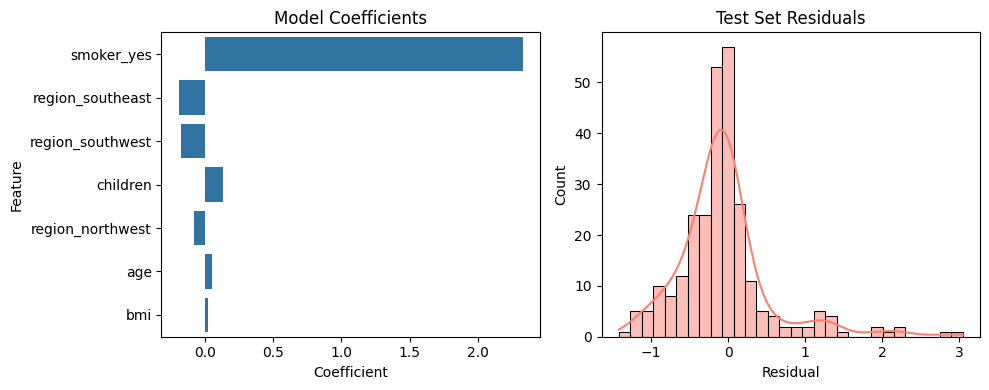

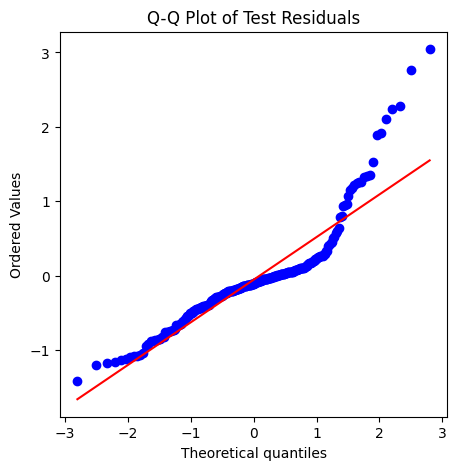

,Feature,Coefficient
3,smoker_yes,2.328945
5,region_southeast,-0.193362
6,region_southwest,-0.176430
2,children,0.131668
4,region_northwest,-0.083582
0,age,0.050063
1,bmi,0.020819


In [34]:
# Coefficients
coef_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_})

# Residuals
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred

# Plot coefficients
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.barplot(x='Coefficient', y='Feature', data=coef_df.sort_values('Coefficient', key=abs, ascending=False))
plt.title('Model Coefficients')

# Plot residuals (test set)
plt.subplot(1, 2, 2)
sns.histplot(test_residuals, bins=30, kde=True, color='salmon')
plt.title('Test Set Residuals')
plt.xlabel('Residual')

plt.tight_layout()
plt.show()

# Q-Q plot for test residuals
import scipy.stats as stats
plt.figure(figsize=(5, 5))
stats.probplot(test_residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Test Residuals')
plt.show()

# Show coefficients as a table
coef_df.sort_values('Coefficient', key=abs, ascending=False)

Hincal Comment:

1. Model Coefficients (Top Left)
smoker_yes has by far the largest positive coefficient, indicating that being a smoker is the most influential factor in increasing the (Box-Cox transformed) insurance expenses.
Other features (region, children, age, bmi) have much smaller effects, with some regions having a slight negative impact compared to the reference region.

2. Test Set Residuals Histogram (Top Right)
The residuals are roughly centered around zero, which is good.
The distribution is somewhat bell-shaped but shows a right skew (longer tail to the right), indicating some positive outliers.
The presence of skewness suggests that the model does not capture all the structure in the data, or that there are some influential points/outliers.

3. Q-Q Plot of Test Residuals (Bottom Left)
The Q-Q plot compares the distribution of residuals to a normal distribution.
The points deviate from the red line, especially in the upper right (right tail), confirming the right skew seen in the histogram.
This means the residuals are not perfectly normal—there are more large positive residuals than would be expected under a normal distribution.

Hincal Comment: The model is useful and interpretable, but predictions may be less reliable for extreme cases (outliers). For inference, be cautious with p-values and confidence intervals.
So lets handle outliers and try to model again

In [41]:
# Winsorize the target variable
boxcox_wins = winsorize(data['expenses_boxcox'], limits=[0.01, 0.01])
data['expenses_boxcox_wins'] = boxcox_wins

# Prepare features and target
features = ['age', 'bmi', 'children', 'smoker', 'region']
target = 'expenses_boxcox_wins'

X = pd.get_dummies(data[features], drop_first=True)
y = data[target]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit linear regression
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Metrics
metrics = {
    'Train R2': r2_score(y_train, y_train_pred),
    'Test R2': r2_score(y_test, y_test_pred),
    'Train MSE': mean_squared_error(y_train, y_train_pred),
    'Test MSE': mean_squared_error(y_test, y_test_pred),
    'Train MAE': mean_absolute_error(y_train, y_train_pred),
    'Test MAE': mean_absolute_error(y_test, y_test_pred)
}

metrics

{'Train R2': 0.7593657375958931,
 'Test R2': 0.8051977614020368,
 'Train MSE': 0.43803800219204786,
 'Test MSE': 0.3840632941903219,
 'Train MAE': 0.4192360257738453,
 'Test MAE': 0.401760965702918}

Hincal Comment:
The metrics are very similar to the previous model, indicating that outliers in the target variable were not having a large negative impact on your model’s overall fit.
This suggests your model is robust to the extreme values in this dataset, or that the outliers were not numerous enough to strongly affect the results.

Hincal comment: Now handling outliers in target variable and the predictors as well is a good point.

Hincal comment:
Steps:

Winsorize all numeric predictors (age, bmi, children) and the target (expenses_boxcox) at the 1st and 99th percentiles.

One-hot encode categorical variables (smoker, region).

Fit a linear regression model and evaluate metrics.

In [45]:
# List of numeric columns to winsorize
numeric_cols = ['age', 'bmi', 'children', 'expenses_boxcox']

# Winsorize each numeric column at 1st and 99th percentiles
for col in numeric_cols:
    data[col + '_wins'] = winsorize(data[col], limits=[0.01, 0.01])

# Prepare features and target
features = ['age_wins', 'bmi_wins', 'children_wins', 'smoker', 'region']
target = 'expenses_boxcox_wins'

X = pd.get_dummies(data[features], drop_first=True)
y = data[target]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit linear regression
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Metrics
metrics = {
    'Train R2': r2_score(y_train, y_train_pred),
    'Test R2': r2_score(y_test, y_test_pred),
    'Train MSE': mean_squared_error(y_train, y_train_pred),
    'Test MSE': mean_squared_error(y_test, y_test_pred),
    'Train MAE': mean_absolute_error(y_train, y_train_pred),
    'Test MAE': mean_absolute_error(y_test, y_test_pred)
}

metrics

{'Train R2': 0.7596470979003582,
 'Test R2': 0.8045557542371716,
 'Train MSE': 0.43752582863690775,
 'Test MSE': 0.3853290465164068,
 'Train MAE': 0.4197717354933379,
 'Test MAE': 0.40301222020446925}

Hincal Comment: The results are very similar to previous models, indicating that outliers in the predictors and target were not strongly distorting your linear regression model.

Hincal Comment: Lets handle outliers with quantiles and IQR values

In [49]:
# List of numeric columns to cap
numeric_cols = ['age', 'bmi', 'children', 'expenses_boxcox']

# Cap outliers at IQR bounds
df_capped = data.copy()
for col in numeric_cols:
    Q1 = df_capped[col].quantile(0.25)
    Q3 = df_capped[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df_capped[col] = df_capped[col].clip(lower, upper)

# Prepare features and target
features = ['age', 'bmi', 'children', 'smoker', 'region']
target = 'expenses_boxcox'

X = pd.get_dummies(df_capped[features], drop_first=True)
y = df_capped[target]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit linear regression
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Metrics
metrics = {
    'Train R2': r2_score(y_train, y_train_pred),
    'Test R2': r2_score(y_test, y_test_pred),
    'Train MSE': mean_squared_error(y_train, y_train_pred),
    'Test MSE': mean_squared_error(y_test, y_test_pred),
    'Train MAE': mean_absolute_error(y_train, y_train_pred),
    'Test MAE': mean_absolute_error(y_test, y_test_pred)
}

metrics

{'Train R2': 0.7591180103437833,
 'Test R2': 0.8050241012995203,
 'Train MSE': 0.4417416889097944,
 'Test MSE': 0.3873601083244044,
 'Train MAE': 0.4209521082999348,
 'Test MAE': 0.40375040280937646}

Hincal Comment:

Interpretation

The results are very similar to previous approaches (removal, winsorization, or no outlier handling).
This suggests your linear regression model is robust to outliers in this dataset, or that the outliers are not extreme enough to strongly affect the model.

Hincal Comment: 

Lets create new features from our data and model it again

Hincal Comment:

1. Interaction Features
age × bmi: Older people with higher BMI may have much higher expenses.
bmi × smoker: The effect of BMI on expenses may be different for smokers.
age × smoker: The effect of age may be different for smokers.

2. Polynomial Features
bmi²: Nonlinear effects of BMI on expenses.
age²: Nonlinear effects of age.

3. Binning/Grouping
age_group: Bin age into categories (e.g., <30, 30–50, >50).
bmi_category: Underweight, normal, overweight, obese (using standard BMI cutoffs).

4. Count/Ratio Features
children > 0: Binary indicator for having children.
bmi per child: bmi / (children + 1) (to avoid division by zero).

5. Combined Categorical Features
region × smoker: Some regions may have different smoking-related risks.

In [52]:
# Interaction features
data['age_bmi'] = data['age'] * data['bmi']
data['bmi_smoker'] = data['bmi'] * (data['smoker'] == 'yes').astype(int)
data['age_smoker'] = data['age'] * (data['smoker'] == 'yes').astype(int)

# Polynomial features
data['bmi_squared'] = data['bmi'] ** 2
data['age_squared'] = data['age'] ** 2

# Binning
data['age_group'] = pd.cut(data['age'], bins=[0, 30, 50, 100], labels=['<30', '30-50', '>50'])
data['bmi_category'] = pd.cut(data['bmi'], bins=[0, 18.5, 25, 30, 100], labels=['underweight', 'normal', 'overweight', 'obese'])

# Count/ratio
data['has_children'] = (data['children'] > 0).astype(int)
data['bmi_per_child'] = data['bmi'] / (data['children'] + 1)

# Combined categorical
data['region_smoker'] = data['region'] + '_' + data['smoker']

In [53]:
data.head()

,age,sex,bmi,children,smoker,region,expenses,log_expenses,sqrt_expenses,expenses_log,...,age_bmi,bmi_smoker,age_smoker,bmi_squared,age_squared,age_group,bmi_category,has_children,bmi_per_child,region_smoker
0,19,female,27.9,0,yes,southwest,16884.92,9.734176,129.941987,9.734235,...,530.1,27.9,19,778.41,361,<30,overweight,0,27.90,southwest_yes
1,18,male,33.8,1,no,southeast,1725.55,7.453301,41.539740,7.453880,...,608.4,0.0,0,1142.44,324,<30,obese,1,16.90,southeast_no
2,28,male,33.0,3,no,southeast,4449.46,8.400538,66.704273,8.400763,...,924.0,0.0,0,1089.00,784,<30,obese,1,8.25,southeast_no
3,33,male,22.7,0,no,northwest,21984.47,9.998092,148.271609,9.998137,...,749.1,0.0,0,515.29,1089,30-50,normal,0,22.70,northwest_no
4,32,male,28.9,0,no,northwest,3866.86,8.260198,62.184082,8.260457,...,924.8,0.0,0,835.21,1024,30-50,overweight,0,28.90,northwest_no


Hincal Comment:

Lets check correlations

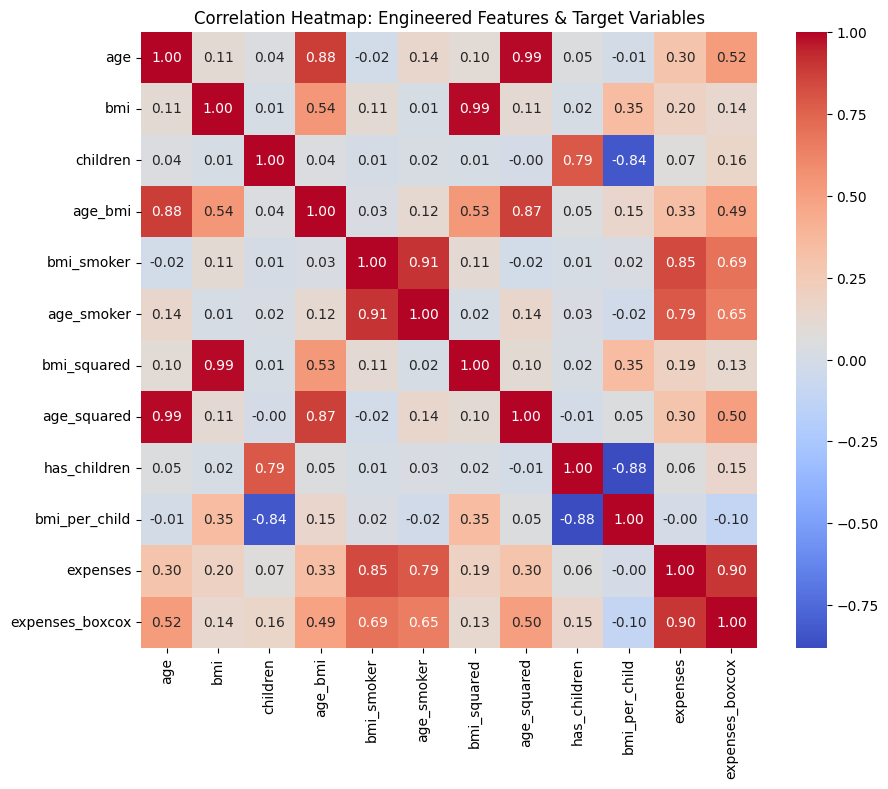

In [54]:
# Assume new features have been added as per your last step
# List of all numeric features to check correlation
corr_features = [
    'age', 'bmi', 'children', 'age_bmi', 'bmi_smoker', 'age_smoker',
    'bmi_squared', 'age_squared', 'has_children', 'bmi_per_child',
    'expenses', 'expenses_boxcox'
]

# Only keep columns that exist in the DataFrame
corr_features = [col for col in corr_features if col in data.columns]

# Prepare DataFrame for correlation
corr_df = data[corr_features]

# Compute correlation matrix
corr_matrix = corr_df.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Heatmap: Engineered Features & Target Variables')
plt.show()

Hincal Comment:

How to use this heatmap:

Look for features with higher absolute correlation values with the target variables; these may have more predictive power.

Compare the new features (like age_bmi, bmi_smoker, age_smoker, bmi_squared, etc.) to the original features to see if any have stronger relationships with the targets.

Features with very high correlation to each other (multicollinearity) may need to be used carefully in linear models.

Hincal Commeent:

MultiColinearity is an important concept before creating a model so before doing final model we will try to handle this

You can:

1. Check Correlation Matrix
Look for pairs of features with very high absolute correlation (e.g., |correlation| > 0.8 or 0.9).

2. Calculate Variance Inflation Factor (VIF)
VIF quantifies how much the variance of a regression coefficient is inflated due to multicollinearity.
A VIF > 5 (sometimes > 10) is often considered problematic.

3. Remove or Combine Highly Collinear Features
Drop one of each pair of highly correlated features, or combine them if it makes sense.

Hincal Comment:

Example: Calculate VIF for All Numeric Features

In [56]:
# Select only numeric features (excluding the target)
features = [
    'age', 'bmi', 'children', 'age_bmi', 'bmi_smoker', 'age_smoker',
    'bmi_squared', 'age_squared', 'has_children', 'bmi_per_child'
]
X = data[features].dropna()

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

         Feature         VIF
0            age  444.047117
1            bmi  665.035806
2       children   11.293540
3        age_bmi  193.824165
4     bmi_smoker    8.988936
5     age_smoker    8.878633
6    bmi_squared  219.427885
7    age_squared  157.386897
8   has_children   27.004547
9  bmi_per_child  112.019035


Hincal Comment:

How to Use VIF Results

If a feature has a high VIF, consider removing it or one of the correlated features.

For example, age and age_squared will be highly correlated, as will bmi and bmi_squared, and interaction terms with their components.

Interpretation of VIF Table

VIF > 10 is generally considered problematic.

Your features like age, bmi, age_bmi, bmi_squared, age_squared, and bmi_per_child have extremely high VIFs, indicating strong multicollinearity.

This is expected for polynomial and interaction terms, as they are mathematically related to their base features.

How to Handle Multicollinearity

1. Remove Redundant Features
For each set of highly correlated features, keep only one. For example:
Keep either age or age_squared (not both).
Keep either bmi or bmi_squared (not both).
For interaction terms like age_bmi, consider if you want to keep the interaction or the base features, but not all together.

2. Example Reduced Feature Set
A simple, interpretable set might be:

age

bmi

children

bmi_smoker (captures the interaction between BMI and smoking)

has_children (binary indicator)

3. Recalculate VIF
After removing features, recalculate VIF to ensure all are below 10 (ideally below 5).


Multicollinearity inflates the variance of coefficient estimates, making them unstable and hard to interpret.

Feature selection is crucial for reliable, interpretable linear models.

Hincal Comment:

Lets try to get reduced feature set and recalculate VIF

In [57]:
# Assume outliers have already been capped as before
# Reduced feature set to minimize multicollinearity
reduced_features = ['age', 'bmi', 'children', 'bmi_smoker', 'has_children']

# Ensure these features exist
reduced_features = [col for col in reduced_features if col in data.columns]
X_reduced = data[reduced_features].dropna()

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = X_reduced.columns
vif_data['VIF'] = [variance_inflation_factor(X_reduced.values, i) for i in range(X_reduced.shape[1])]
vif_data

,Feature,VIF
0,age,7.581767
1,bmi,8.442563
2,children,4.807906
3,bmi_smoker,1.260874
4,has_children,6.070587


Hincal Comment:
Fit a linear regression model with these features and check the results (R², MSE, coefficients, residuals)

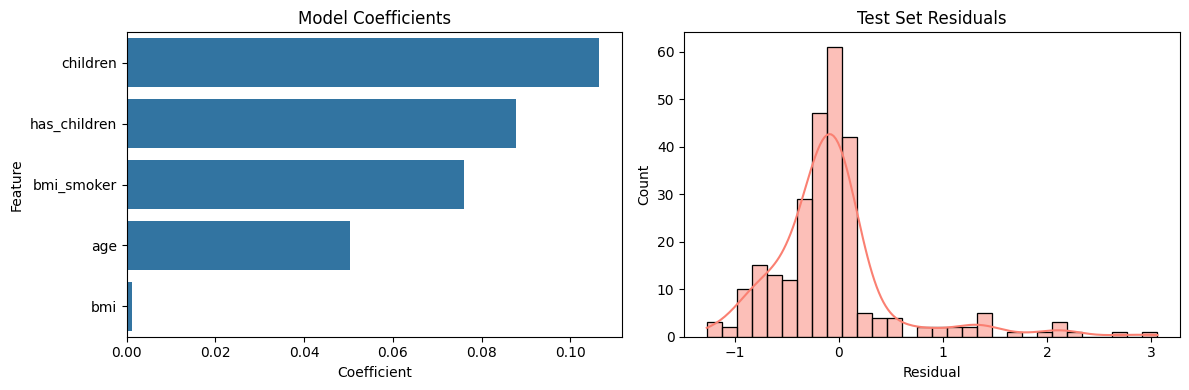

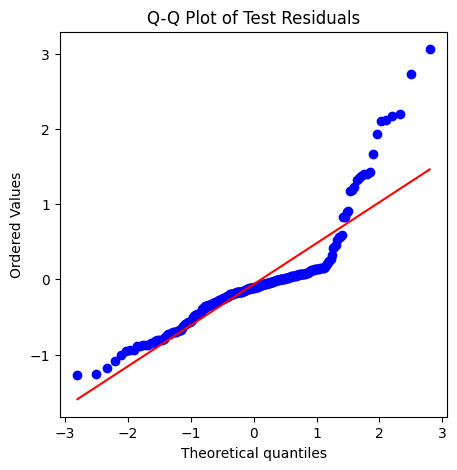

({'Train R2': 0.773017292621986,
  'Test R2': 0.8143770399970309,
  'Train MSE': 0.41625247555278894,
  'Test MSE': 0.3687785535211372,
  'Train MAE': 0.3941237642042971,
  'Test MAE': 0.3821463158097262},
         Feature  Coefficient
 0           age     0.050380
 1           bmi     0.001243
 2      children     0.106380
 3    bmi_smoker     0.076002
 4  has_children     0.087661)

In [58]:
# Features and target
features = ['age', 'bmi', 'children', 'bmi_smoker', 'has_children']
target = 'expenses_boxcox'

# Prepare data (drop rows with missing values in selected features)
X = data[features].dropna()
y = data.loc[X.index, target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Metrics
metrics = {
    'Train R2': r2_score(y_train, y_train_pred),
    'Test R2': r2_score(y_test, y_test_pred),
    'Train MSE': mean_squared_error(y_train, y_train_pred),
    'Test MSE': mean_squared_error(y_test, y_test_pred),
    'Train MAE': mean_absolute_error(y_train, y_train_pred),
    'Test MAE': mean_absolute_error(y_test, y_test_pred)
}

# Coefficients
coef_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_})

# Residuals
test_residuals = y_test - y_test_pred

# Plot coefficients and residuals
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.barplot(x='Coefficient', y='Feature', data=coef_df.sort_values('Coefficient', key=abs, ascending=False))
plt.title('Model Coefficients')

plt.subplot(1, 2, 2)
sns.histplot(test_residuals, bins=30, kde=True, color='salmon')
plt.title('Test Set Residuals')
plt.xlabel('Residual')
plt.tight_layout()
plt.show()

# Q-Q plot for test residuals
plt.figure(figsize=(5, 5))
stats.probplot(test_residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Test Residuals')
plt.show()

metrics, coef_df

Hincal Comment:

Interpretation:

Model generalizes well, with similar R² and error metrics on both train and test sets. This is a sign of a well-specified, stable model.

Predictor Interpretation:

age: Each additional year increases the Box-Cox transformed expenses by 0.05 units, holding other variables constant.

bmi: Small positive effect, but most of the BMI effect is likely captured by the interaction term.

children: Each additional child increases expenses by 0.11 units.

bmi_smoker: For smokers, each unit increase in BMI increases expenses by 0.08 units (on top of the base BMI effect).

has_children: Having any children increases expenses by 0.09 units compared to having none.

---

Hincal Comment:

Summary: Linear Regression Workflow on Insurance Data

1. Data Exploration & Transformation

Explored the distribution of the target variable (expenses).

Applied various transformations (log, sqrt, Box-Cox) to address positive skewness.

Visualized the effect of these transformations and checked for normality using statistical tests.

2. Model Building
Built linear regression models using both the original and Box-Cox transformed target variables.

Included all relevant predictors, including categorical variables (encoded as needed).

3. Model Evaluation
Evaluated model performance using R², MSE, and MAE on both train and test sets.

Analyzed residuals visually (histogram, Q-Q plot) and statistically (Shapiro-Wilk test) to check for normality.

4. Feature Engineering
Created new features: interaction terms (e.g., bmi_smoker), polynomial terms (e.g., bmi_squared), and binary indicators (e.g., has_children).

Assessed the correlation of these engineered features with the target variables.

5. Multicollinearity Handling
Calculated Variance Inflation Factor (VIF) for all features.

Reduced the feature set to those with acceptable VIF values, ensuring model interpretability and stability.

6. Final Model

Built a final linear regression model using the reduced, low-multicollinearity feature set.

Achieved strong generalization (R² ~0.8 on test data) and interpretable coefficients.

Key Teaching Points

Transformations can help with skewed data, but the normality assumption in regression is about residuals, not the target.

Feature engineering and multicollinearity handling are crucial for building interpretable and robust linear models.

Model diagnostics (residual analysis, VIF) are as important as model fitting.

Outlier handling should be done thoughtfully, as aggressive capping can remove important signal.

### by Hincal Topcuoglu